# Encoder scaled dot-product attention

Como hemos contado el bloque de atención está compuesto por el bloque `Scaled Dot-Prooduct Attention`

<div style="text-align:center;">
  <img src="Imagenes/multi-head_attention.png" alt="Multi-Head Attention" style="width:501px;height:623px;">
</div>

De modo que vamos a ver cómo es su arquitectura

<div style="text-align:center;">
  <img src="Imagenes/Scaled_Dot-Product_Attention.png" alt="Scaled_Dot-Product_Attention">
</div>

Esta arquitectura se define también con la siguiente fórmula

<div style="text-align:center;">
  <img src="Imagenes/Scaled_Dot-Product_Attention_formula.png" alt="Scaled Dot-Product Attention formula">
</div>

Así en frío puede parecer complicado, pero vamos a ir explicando todo poco a poco para entender cómo funciona este mecanismo de atención, que constituye la parte principal de la arquitectura Transformer

## Similitud entre vectores (MatMul)

La forma que tenemos de calcular la similitud entre dos vectores consiste en calcular el producto escalar entre ambos, pero esto ¿por qué se hace? El producto escalar entre dos vectores U y V se puede descomponer entre el producto de sus normas multiplicado por el coseno del ángulo que los separa

$$\mathbf{U} \cdot \mathbf{V} = |\mathbf{U}| \cdot |\mathbf{V}| \cos(\theta)$$

Por lo que, valga lo que valga el producto de sus normas:
 + Si el ángulo que los separa es de 0º, su coseno valdrá 1, lo que quiere decir que los dos vectores son similares.
 + Si el ángulo que los separa vale 180º, su coseno valdrá -1, lo que quiere decir que los dos vectores son opuestos o antagónicos.
 + Pero si el ángulo que los separa es de 90º o 270º, su coseno valdrá 0, por lo que los vectores no tendrán ninguna similitud.

En el siguiente gif se puede ver una muestra de este comportamiento

<div style="text-align:center;">
  <img src="Imagenes/dot-product-unity.gif" alt="dot product">
</div>

Volviendo al producto escalar, en el siguiente gif podemos ver cómo a medida que cambia el ángulo entre los vectores, el producto entre ambos cambia entre el producto de sus normas, cero o el valor negativo del producto de sus normas

<div style="text-align:center;">
  <img src="Imagenes/dot-product.gif" alt="dot product">
</div>

Ya sabemos qué hace el bloque `MatMul` de `Scaled Dot-Product Attention`, ahora vamos a explicar el bloque entero y cómo consigue calcular la atención entre distintos tokens

## Scaled dot-product attention

Vamos a volver a ver la arquitectura y la fórmula del `Scaled dot-product attention`


<div style="text-align:center;">
  <img src="Imagenes/Scaled_Dot-Product_Attention.png" alt="Scaled_Dot-Product_Attention">
  <img src="Imagenes/Scaled_Dot-Product_Attention_formula.png" alt="Scaled Dot-Product Attention formula">
</div>

Como vemos tenemos que hacer unas operaciones con `Q`, `K` y `V`. Estos nombres vienen de `query`, `key` y `value` de las bases de datos y hace una especie de similitud de lo que haces en una base de datos para obtener información, pero no vamos a hacer la explicación centrándonos en el paradigma de las bases de datos. Así que solo quédate que tienen esos nombres por esa razón

Para saber qué es `Q`, `K` y `V` volvamos a ver la arquitectura general del transformer

<div style="text-align:center;">
  <img src="Imagenes/transformer_architecture_model_encoder_multi_head_attention.png" alt="Multi-Head Attention" style="width:425px;height:626px;">
</div>

Como vemos la salida del `positional encoding`, se divide en tres y entra al módulo de `Multi-Head Attention`, por lo que tanto `Q`, `K` y `V` son el conjunto de vectores (es decir, la matriz) correspondientes a la frase que esté entrando al transformer

Vamos a recordar el camino de una frase cuando entra a un transformer

 1. Primero entra al tokenizador y cada palabra se divide en tokens más sencillos que corresponden a un ID
 2. Después entran al `Input embedding` donde son convertidas a un espacio vectorial, por lo que cada token se convertirá en un vector
 3. A continuación a cada vector se le sumará otro para dar información de la posición del token en la frase
 4. La matriz resultante se triplica y entra al `Multi-Head attention`

<div style="text-align:center;">
  <img src="Imagenes/camino_frase_transformer.png" alt="Multi-Head Attention">
</div>

Por tanto, tanto `Q`, como `K`, como `V` van a ser la matriz resultante del `input embedding` más el `positional encoding`. En resumen, la frase de entrada al transformer, se convierte en una matriz, donde cada fila corresponde a uno de los tokens de la frase y cada columna a la dimensión del embedding.

Esa matriz se triplica y entra al módulo de `Multi-Head Attention`. Por lo que en este caso, esa matriz va a ser `Q`, `K` y `V` y para simplificar la vamos a llamar `X`.

### MatMul

Lo primero que hacemos es la operación `MatMul` de `Q` con `V`, pero que en realidad corresponde a la matriz `X` consigo misma

<div style="text-align:center;">
  <img src="Imagenes/Scaled_Dot-Product_Attention_first_MatMul.png" alt="MatMul">
  <img src="Imagenes/Scaled_Dot-Product_Attention_formula.png" alt="Scaled Dot-Product Attention formula">
</div>

Pero como vemos en la fórmula, para poder realizar la operación `K` tiene que estar transpuesta, veamos por qué

La matriz `X` se compone del conjunto de vectores de embeddings de la frase

$$X = \begin{pmatrix}
v_1 \\
v_2 \\
\vdots\\
v_m \\
\end{pmatrix}$$

Donde `m` es el número de tokens de la frase

Cada vector va a tener tantos elementos como las dimensiones de nuestro embedding, supongamos que es `n`, por tanto

$$X = \begin{pmatrix}
v_{1,1} & v_{1,2} & \cdots & v_{1,n} \\
v_{2,1} & v_{2,2} & \cdots & v_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
v_{m,1} & v_{m,2} & \cdots & v_{m,n} \\
\end{pmatrix}$$

Así que para poder multiplicar `X` consigo misma necesitamos que esté transpuesta

$$X \cdot X^T = \begin{pmatrix}
v_{1,1} & v_{1,2} & \cdots & v_{1,n} \\
v_{2,1} & v_{2,2} & \cdots & v_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
v_{m,1} & v_{m,2} & \cdots & v_{m,n} \\
\end{pmatrix} \cdot \begin{pmatrix}
v_{1,1} & v_{1,2} & \cdots & v_{1,m} \\
v_{2,1} & v_{2,2} & \cdots & v_{2,m} \\
\vdots & \vdots & \ddots & \vdots \\
v_{n,1} & v_{n,2} & \cdots & v_{n,m} \\
\end{pmatrix}$$

Para que así la multiplicación sea una multiplicación de matrices de dimensiones $\left(m \times n\right) \cdot \left(n \times m\right)$ que dará como resultado una matriz de tamaño $\left(m \times m\right)$ donde `m` era el número de tokens de la frase

Una vez hemos explicado por qué se tiene que multiplicar la matriz por ella misma transpuesta vamos a ver qué supone esto, si desarrollasemos la multiplicación matricial de antes llegaríamos a esto

$$X \cdot X^T = \begin{pmatrix}
v_1 \cdot v_1 & v_1 \cdot v_2 & \cdots & v_1 \cdot v_m \\
v_2 \cdot v_1 & v_2 \cdot v_2 & \cdots & v_2 \cdot v_m \\
\vdots & \vdots & \ddots & \vdots \\
v_m \cdot v_1 & v_m \cdot v_2 & \cdots & v_m \cdot v_m \\
\end{pmatrix}$$

<div style="text-align:center;">
  <img src="Imagenes/Transformer - matmul.png" alt="MatMul">
</div>


Es decir, tendríamos una matriz con los productos escalares de los vectores de cada token de la frase, y como hemos explicado antes, el producto escalar entre dos vectores nos da la similitud entre estos. Por lo que hemos conseguido una matriz que nos da la similitud de cada token con el resto de tokens de la frase. Obviamente en la diagonal vamos a tener que la similitud va a ser el máximo, ya que se calcula la similitud de un token consigo mismo.

Vamos a ver un ejemplo con dos frases en la que se le da un hueso a un perro

 1. `I gave the dog a bone because it was hungry`
 2. `I gave the dog a bone because it was old`

En el primera frase el `it` se refiere al perro que tiene hambre, mientras que en la segunda el `it` se refiere al hueso que está viejo

Primero vamos a hacer una función que nos devolverá los tokens, el input embeding, el positional encoding y la suma del input embeding y del positional encoding de BERT. Este código no es necesario saberlo, pero lo utilizamos para poder ver resultados con un modelo ya entrenado

In [8]:
import torch
from transformers import BertModel, BertTokenizer

def extract_embeddings(input_sentences, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    
    # tokenización de lote
    inputs = tokenizer(input_sentences, return_tensors='pt', padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    token_embeddings = outputs[0]
    
    # Los embeddings posicionales están en la segunda capa de los embeddings de la arquitectura BERT
    positional_encodings = model.embeddings.position_embeddings.weight[:token_embeddings.shape[1], :].detach().unsqueeze(0).repeat(token_embeddings.shape[0], 1, 1)

    embeddings_with_positional_encoding = token_embeddings + positional_encodings

    # convierte las IDs de los tokens a tokens
    tokens = [tokenizer.convert_ids_to_tokens(input_id) for input_id in inputs['input_ids']]

    return tokens, inputs['input_ids'], token_embeddings, positional_encodings, embeddings_with_positional_encoding

Ahora analizamos la primera frase `I gave the dog a bone because it was hungry`

In [9]:
sentence1 = "I gave the dog a bone because it was hungry"
tokens1, input_ids1, token_embeddings1, positional_encodings1, embeddings_with_positional_encoding1 = extract_embeddings(sentence1)

In [10]:
print(f"Frase de entrada: {sentence1}")
print(f"Tokens: {tokens1}")
print(f"Len tokens: {len(tokens1[0])}")
print(f"IDs de los tokens: {input_ids1}")
print(f"Input embeddings shape: {token_embeddings1.shape}")
print(f"Positional encodings shape: {positional_encodings1.shape}")
print(f"Input embeddings with positional encoding shape: {embeddings_with_positional_encoding1.shape}")

Frase de entrada: I gave the dog a bone because it was hungry
Tokens: [['[CLS]', 'i', 'gave', 'the', 'dog', 'a', 'bone', 'because', 'it', 'was', 'hungry', '[SEP]']]
Len tokens: 12
IDs de los tokens: tensor([[ 101, 1045, 2435, 1996, 3899, 1037, 5923, 2138, 2009, 2001, 7501,  102]])
Input embeddings shape: torch.Size([1, 12, 768])
Positional encodings shape: torch.Size([1, 12, 768])
Input embeddings with positional encoding shape: torch.Size([1, 12, 768])


Como se puede ver tanto el input embedding, como el positional encoding como la suma de ambos es una matriz de 1x12x768, 12 es porque es el número de tokens en los que se ha dividido la frase, 768 porque es la dimensión de embeding de BERT y el 1 es por el batch size

Ahora vamos a llamar a la suma del input embeding y del positional encoding `X1` y la vamos a multiplicar por ella misma traspuesta

In [11]:
X1 = embeddings_with_positional_encoding1.squeeze(0)
MatMul1 = torch.matmul(X1, X1.transpose(0,1))
print(f"X shape: {X1.shape}")
print(f"X·X^T shape: {MatMul1.shape}")

X shape: torch.Size([12, 768])
X·X^T shape: torch.Size([12, 12])


Como habíamos dicho la multiplicación produce una matriz de dimensiones $\left(m \times m\right)$ donde en este caso `m` es 12

 > Hay que fijarse en que estamos haciendo un `squeeze(0)` a `embeddings_with_positional_encoding1`, es decir, estamos quitando el batch size

Vamos a representar la matriz como números enteros por facilidad a la hora de verla

In [12]:
MatMul1.detach().numpy().astype(int)

array([[203,  85,  13,  26,  33,  25,  30,  16,  29,  24,  40, -22],
       [ 85, 185,  83,  72,  53,  71,  60,  96,  64,  64,  56,   0],
       [ 13,  83, 196, 103,  65, 123,  78, 124,  83, 108,  58,  29],
       [ 26,  72, 103, 214, 136, 161, 105,  94, 173, 156,  74,  29],
       [ 33,  53,  65, 136, 183, 106, 118,  55, 138, 116,  73,   2],
       [ 25,  71, 123, 161, 106, 210, 121, 118, 152, 164,  79,  37],
       [ 30,  60,  78, 105, 118, 121, 208,  74, 111, 104,  77,  11],
       [ 16,  96, 124,  94,  55, 118,  74, 219,  85, 112,  75,  34],
       [ 29,  64,  83, 173, 138, 152, 111,  85, 222, 185,  82,  21],
       [ 24,  64, 108, 156, 116, 164, 104, 112, 185, 233,  89,  30],
       [ 40,  56,  58,  74,  73,  79,  77,  75,  82,  89, 215,  22],
       [-22,   0,  29,  29,   2,  37,  11,  34,  21,  30,  22, 229]])

Vamos a representarla ahora gráficamente, para ello creamos una función que nos permita visualizar la matriz

In [24]:
import matplotlib.pyplot as plt

def plot_matrix(positional_encoding_matrix):
    plt.figure(figsize=(15, 8))
    plt.imshow(positional_encoding_matrix, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Index of Word Embedding Dimension')
    plt.ylabel('Position in Sequence')
    plt.title('Positional Encoding Visualization')
    plt.show()

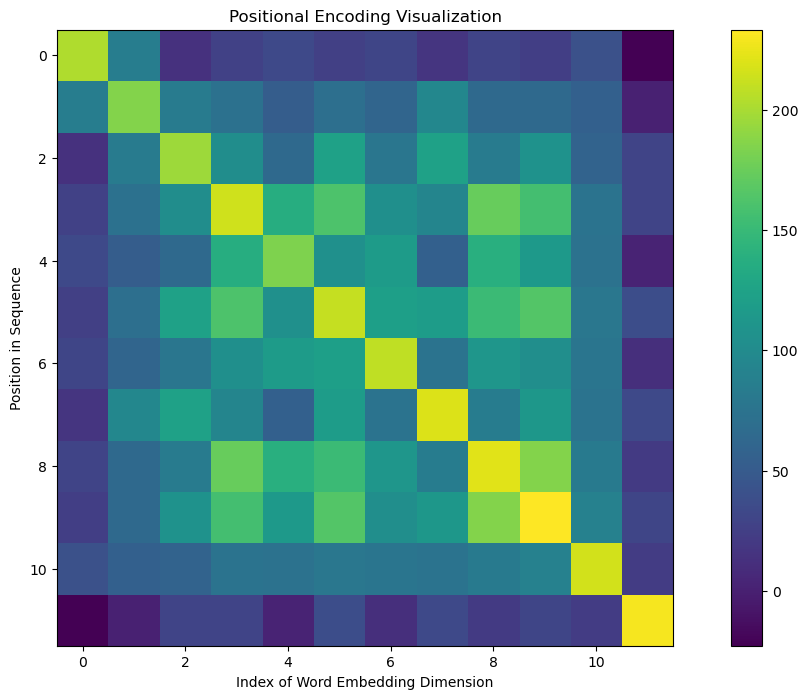

In [15]:
plot_matrix(MatMul1.detach().numpy())

Los números más grandes están en la diagonal, lo cual es lógico porque corresponden a la similitud de todos los tokens consigo mismos. Además es simétrica, lo cual es lógico, porque la similitud del token 3 con el token 2 es la misma que la del token 2 con el token 3

Vamos a volver a ver los tokens y sus IDs

In [6]:
for i, token in enumerate(tokens1[0]):
    print(f"El token \"{token}\" es el número {i} y tiene el ID {input_ids1[0][i]}")

El token "[CLS]" es el número 0 y tiene el ID 101
El token "i" es el número 1 y tiene el ID 1045
El token "gave" es el número 2 y tiene el ID 2435
El token "the" es el número 3 y tiene el ID 1996
El token "dog" es el número 4 y tiene el ID 3899
El token "a" es el número 5 y tiene el ID 1037
El token "bone" es el número 6 y tiene el ID 5923
El token "because" es el número 7 y tiene el ID 2138
El token "it" es el número 8 y tiene el ID 2009
El token "was" es el número 9 y tiene el ID 2001
El token "hungry" es el número 10 y tiene el ID 7501
El token "[SEP]" es el número 11 y tiene el ID 102


Vamos a ver el resultado de la multiplicación del token 8 `it` con el token 4 `dog` y con el token 10 `hungry`

In [7]:
MatMul1[8,4].item(), MatMul1[8,10].item(), torch.max(MatMul1), torch.min(MatMul1)

(138.7621307373047, 82.4168930053711, tensor(233.4600), tensor(-22.9223))

La similitud es mucho mayor entre el token `it` con el token `dog` que con el token `hungry`.

Además la similitud entre el token `it` con el token `dog` es casi como el máximo de toda la matriz, el cual corresponde a la similitud de algún token consigo mismo. Por lo que podemos decir que ambas palabras tienen mucha similitud

Si ahora hacemos lo mismo pero con la frase `I gave the dog a bone because it was old`

In [18]:
sentence2 = "I gave the dog a bone because it was old"
tokens2, input_ids2, token_embeddings2, positional_encodings2, embeddings_with_positional_encoding2 = extract_embeddings(sentence2)

In [19]:
X2 = embeddings_with_positional_encoding2.squeeze(0)
MatMul2 = torch.matmul(X2, X2.transpose(0,1))

 > Hay que fijarse en que estamos haciendo un `squeeze(0)` a `embeddings_with_positional_encoding2`, es decir, estamos quitando el batch size

In [20]:
MatMul2[8,4].item(), MatMul2[8,10].item(), torch.max(MatMul2), torch.min(MatMul2)

(120.86178588867188, 120.17017364501953, tensor(231.0643), tensor(-20.8980))

Ahora la similitud entre el token `it` es casi la misma con los tokens `dog` y `old`. 

Gracias a esta multiplicación podemos ir viendo similitudes entre palabras

### Scale

Ya hemos hecho la operación de `MatMul`

Ahora toca la de `Scale`, que como vemos en la fórmula es simplemente dividir `MatMul` entre la raiz de la dimensión del embeding de `K`

<div style="text-align:center;">
  <img src="Imagenes/Scaled_Dot-Product_Attention_scale.png" alt="MatMul">
  <img src="Imagenes/Scaled_Dot-Product_Attention_formula.png" alt="Scaled Dot-Product Attention formula">
</div>

¿Esto por qué? Veamos otra vez `MatMul` en forma de enteros, los decimales ahora no nos interesan

In [11]:
MatMul1.detach().numpy().astype(int)

array([[203,  85,  13,  26,  33,  25,  30,  16,  29,  24,  40, -22],
       [ 85, 185,  83,  72,  53,  71,  60,  96,  64,  64,  56,   0],
       [ 13,  83, 196, 103,  65, 123,  78, 124,  83, 108,  58,  29],
       [ 26,  72, 103, 214, 136, 161, 105,  94, 173, 156,  74,  29],
       [ 33,  53,  65, 136, 183, 106, 118,  55, 138, 116,  73,   2],
       [ 25,  71, 123, 161, 106, 210, 121, 118, 152, 164,  79,  37],
       [ 30,  60,  78, 105, 118, 121, 208,  74, 111, 104,  77,  11],
       [ 16,  96, 124,  94,  55, 118,  74, 219,  85, 112,  75,  34],
       [ 29,  64,  83, 173, 138, 152, 111,  85, 222, 185,  82,  21],
       [ 24,  64, 108, 156, 116, 164, 104, 112, 185, 233,  89,  30],
       [ 40,  56,  58,  74,  73,  79,  77,  75,  82,  89, 215,  22],
       [-22,   0,  29,  29,   2,  37,  11,  34,  21,  30,  22, 229]])

Tenemos una matriz con números muy grandes. En las redes neuronales nos conviene tener números más pequeños, entre 0 y 1 sería lo ideal. De modo que se divide entre la raiz de la dimensión del embeding, porque este tipo de normalización se ha visto que va bien en los modelos de atención. A este tipo de atención se le suele llamar norma L2. Os recomiendo el capítulo [Investigación básica en Layer 6 - Felipe Pérez](https://open.spotify.com/episode/5oymLELbSbcWRAUldqVI9I) del podcast [Software 2.0](https://open.spotify.com/show/6nUgq0q9wVP6hMekW0dUqm) donde se explica un poco y hablan mucho más de transformers

Hacemos la operación

In [21]:
Scale1 = MatMul1 / torch.sqrt(torch.tensor(X1.shape[1]))
Scale2 = MatMul2 / torch.sqrt(torch.tensor(X2.shape[1]))

Veamos ahora una de las matrices

In [22]:
Scale1.detach().numpy().astype(int)

array([[7, 3, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [3, 6, 3, 2, 1, 2, 2, 3, 2, 2, 2, 0],
       [0, 3, 7, 3, 2, 4, 2, 4, 3, 3, 2, 1],
       [0, 2, 3, 7, 4, 5, 3, 3, 6, 5, 2, 1],
       [1, 1, 2, 4, 6, 3, 4, 2, 5, 4, 2, 0],
       [0, 2, 4, 5, 3, 7, 4, 4, 5, 5, 2, 1],
       [1, 2, 2, 3, 4, 4, 7, 2, 4, 3, 2, 0],
       [0, 3, 4, 3, 2, 4, 2, 7, 3, 4, 2, 1],
       [1, 2, 3, 6, 5, 5, 4, 3, 8, 6, 2, 0],
       [0, 2, 3, 5, 4, 5, 3, 4, 6, 8, 3, 1],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 7, 0],
       [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 8]])

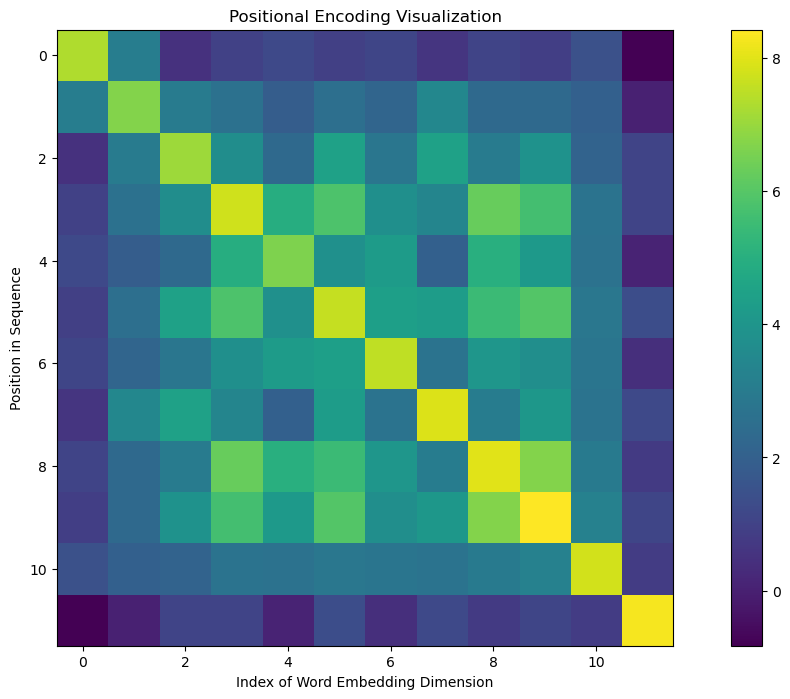

In [25]:
plot_matrix(Scale1.detach().numpy())

Se ha reducido considerablemente

### Mask (opcional)

Ahora tocaría hacer la parte de `Mask`, pero como vemos es opcional. Esto es porque solo hará falta en la parte del decoder, por lo que ahora por no complicar más no lo explicaremos

<div style="text-align:center;">
  <img src="Imagenes/Scaled_Dot-Product_Attention_mask.png" alt="MatMul">
  <img src="Imagenes/Scaled_Dot-Product_Attention_formula.png" alt="Scaled Dot-Product Attention formula">
</div>

### SoftMax

Después de `Mask` viene la parte de `SoftMax`

<div style="text-align:center;">
  <img src="Imagenes/Scaled_Dot-Product_Attention_softmax.png" alt="MatMul">
  <img src="Imagenes/Scaled_Dot-Product_Attention_formula.png" alt="Scaled Dot-Product Attention formula">
</div>

Ya aprendimos lo que hacía la función softmax en el tema de funciones de activación, pero como resumen, es como si calculara el porcentaje de cada elemento de un vector en el total. Así gracias a la función softmax obtendremos el peso de un elemento en un conjunto, todos los valores estarán entre 0 y 1 y la suma de todos los elementos sumarán 1

Realizamos la operación

In [27]:
Softmax1 = torch.nn.functional.softmax(Scale1, dim=1)
Softmax2 = torch.nn.functional.softmax(Scale2, dim=1)

In [28]:
Softmax1

tensor([[9.7031e-01, 1.3877e-02, 1.0182e-03, 1.6586e-03, 2.1014e-03, 1.5924e-03,
         1.9108e-03, 1.1444e-03, 1.8453e-03, 1.5147e-03, 2.7540e-03, 2.7579e-04],
        [2.2876e-02, 8.4797e-01, 2.1497e-02, 1.4100e-02, 7.0447e-03, 1.3543e-02,
         9.2564e-03, 3.3329e-02, 1.0697e-02, 1.0742e-02, 7.8917e-03, 1.0480e-03],
        [1.0578e-03, 1.3547e-02, 7.7258e-01, 2.7205e-02, 6.8405e-03, 5.6549e-02,
         1.0987e-02, 5.8102e-02, 1.3237e-02, 3.2555e-02, 5.4398e-03, 1.9043e-03],
        [7.0157e-04, 3.6180e-03, 1.1077e-02, 6.1392e-01, 3.6599e-02, 9.1732e-02,
         1.1837e-02, 7.9519e-03, 1.4139e-01, 7.6484e-02, 3.9107e-03, 7.7809e-04],
        [2.6332e-03, 5.3549e-03, 8.2512e-03, 1.0842e-01, 5.9451e-01, 3.6513e-02,
         5.6040e-02, 5.9247e-03, 1.1813e-01, 5.2106e-02, 1.1233e-02, 8.7901e-04],
        [7.6870e-04, 3.9657e-03, 2.6277e-02, 1.0469e-01, 1.4066e-02, 6.0881e-01,
         2.4606e-02, 2.1786e-02, 7.3740e-02, 1.1482e-01, 5.3073e-03, 1.1641e-03],
        [1.3645e-03, 4

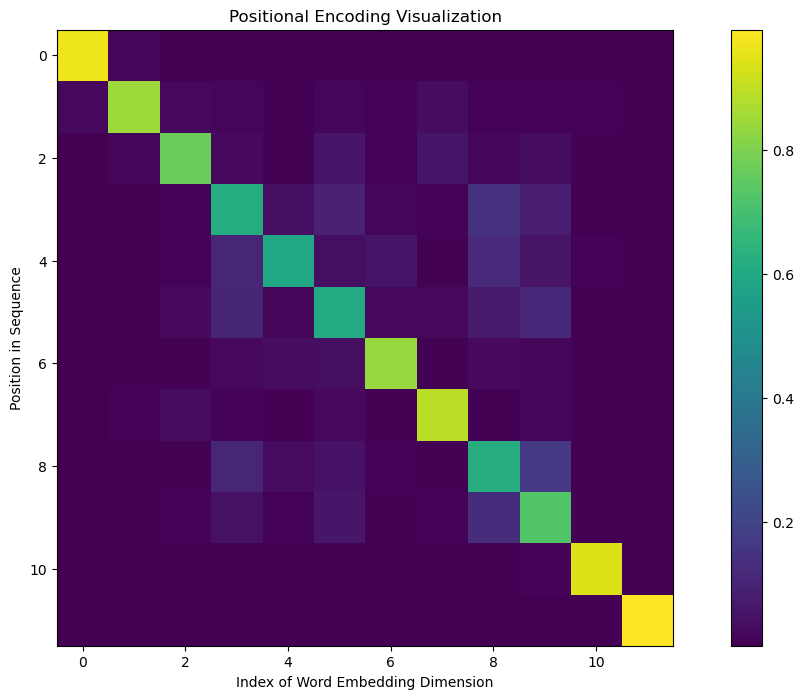

In [29]:
plot_matrix(Softmax1.detach().numpy())

Como vemos obtenemos valores entre 0 y 1. Además la suma de cada vector es 1

In [16]:
torch.sum(Softmax1, dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])

Las matrices `Softmax1` y `Softmax2` que hemos obtenido se llaman `matrices de atención` porque gracias a la softmax representan el porcentaje de atención que tiene un token sobre otro. Es decir, van a representar cuánta atención tiene que prestarle un token a otro. Esto lo vamos a entender mejor en cuanto hagámos la última operación

### MatMul

Llegamos a la última `MatMul`

<div style="text-align:center;">
  <img src="Imagenes/Scaled_Dot-Product_Attention_second_MatMul.png" alt="MatMul">
  <img src="Imagenes/Scaled_Dot-Product_Attention_formula.png" alt="Scaled Dot-Product Attention formula">
</div>

Como hemos visto hasta ahora, lo que hemos conseguido es la matriz que nos dice qué porcentaje de atención tiene que prestar cada token a otro en la frase, por lo que ahora multiplicamos esa matriz otra vez a `X` 

Vamos a volver a recordar cómo era la matriz `X`

$$X = \begin{pmatrix}
v_1 \\
v_2 \\
\vdots\\
v_m \\
\end{pmatrix}$$

Donde `m` es el número de tokens de la frase

Cada vector va a tener tantos elementos como las dimensiones de nuestro embedding, supongamos que es `n`, por tanto

$$X = \begin{pmatrix}
v_{1,1} & v_{1,2} & \cdots & v_{1,n} \\
v_{2,1} & v_{2,2} & \cdots & v_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
v_{m,1} & v_{m,2} & \cdots & v_{m,n} \\
\end{pmatrix}$$

Tenemos una matriz de $\left(m \times n\right)$ donde `m` es el número de tokens y `n` la dimensión del embedding

Ahora vamos a recordar qué es nuestra matriz tras el softmax

$$
\text{Softmax} = \text{softmax}\left( \frac{1}{\sqrt{d_k}} \cdot \left( X \cdot X^T \right) \right) = \text{softmax}\left( \frac{1}{\sqrt{d_k}} \cdot \begin{pmatrix}
v_1 \cdot v_1 & v_1 \cdot v_2 & \cdots & v_1 \cdot v_m \\
v_2 \cdot v_1 & v_2 \cdot v_2 & \cdots & v_2 \cdot v_m \\
\vdots & \vdots & \ddots & \vdots \\
v_m \cdot v_1 & v_m \cdot v_2 & \cdots & v_m \cdot v_m \\
\end{pmatrix} \right)
$$

La cual podemos simplemente suponer como porcentajes de atención

$$
\text{Softmax} = \begin{pmatrix}
p_{1,1} & p_{1,2} & \cdots & p_{1,m} \\
p_{2,1} & p_{2,2} & \cdots & p_{2,m} \\
\vdots & \vdots & \ddots & \vdots \\
p_{m,1} & p_{m,2} & \cdots & p_{m,m} \\
\end{pmatrix}
$$

Tenemos una matriz de $\left(m \times m\right)$ donde `m` es el número de tokens

Por tanto, si las multiplicamos, vamos a obtener esto

$$
\text{Softmax} \cdot X = \begin{pmatrix}
p_{1,1} & p_{1,2} & \cdots & p_{1,m} \\
p_{2,1} & p_{2,2} & \cdots & p_{2,m} \\
\vdots & \vdots & \ddots & \vdots \\
p_{m,1} & p_{m,2} & \cdots & p_{m,m} \\
\end{pmatrix} \cdot \begin{pmatrix}
v_{1,1} & v_{1,2} & \cdots & v_{1,n} \\
v_{2,1} & v_{2,2} & \cdots & v_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
v_{m,1} & v_{m,2} & \cdots & v_{m,n} \\
\end{pmatrix}
$$

$$
\text{Softmax} \cdot X = \begin{pmatrix}
p_{1,1}v_{1,1} + p_{1,2}v_{2,1} + \cdots + p_{1,m}v_{m,1} & p_{1,1}v_{1,2} + p_{1,2}v_{2,2} + \cdots + p_{1,m}v_{m,2} & \cdots & p_{1,1}v_{1,n} + p_{1,2}v_{2,n} + \cdots + p_{1,m}v_{m,n} \\
p_{2,1}v_{1,1} + p_{2,2}v_{2,1} + \cdots + p_{2,m}v_{m,1} & p_{2,1}v_{1,2} + p_{2,2}v_{2,2} + \cdots + p_{2,m}v_{m,2} & \cdots & p_{2,1}v_{1,n} + p_{2,2}v_{2,n} + \cdots + p_{2,m}v_{m,n} \\
\vdots & \vdots & \ddots & \vdots \\
p_{m,1}v_{1,1} + p_{m,2}v_{2,1} + \cdots + p_{m,m}v_{m,1} & p_{m,1}v_{1,2} + p_{m,2}v_{2,2} + \cdots + p_{m,m}v_{m,2} & \cdots & p_{m,1}v_{1,n} + p_{m,2}v_{2,n} + \cdots + p_{m,m}v_{m,n} \\
\end{pmatrix}
$$

Que, aunque no se vea bien, es una matriz de dimensión $\left(m \times n\right)$, donde `m` es el número de tokens, y `n` es la dimensión del embedding

La dejamos menos desarrollada para que se vea mejor

$$
\text{Softmax} \cdot X = \begin{pmatrix}
p_{1,1} & p_{1,2} & \cdots & p_{1,m} \\
p_{2,1} & p_{2,2} & \cdots & p_{2,m} \\
\vdots & \vdots & \ddots & \vdots \\
p_{m,1} & p_{m,2} & \cdots & p_{m,m} \\
\end{pmatrix} \cdot \begin{pmatrix}
v_1 \\
v_2 \\
\vdots\\
v_m \\
\end{pmatrix} = \begin{pmatrix}
p_{1,1}v_1 + p_{1,2}v_2 + \cdots + p_{1,m}v_m \\
p_{2,1}v_1 + p_{2,2}v_2 + \cdots + p_{2,m}v_m \\
\vdots \\
p_{m,1}v_1 + p_{m,2}v_2 + \cdots + p_{m,m}v_m \\
\end{pmatrix}
$$

Es decir, antes de todo el `Scaled Dot-Product Attention` teníamos una matriz `X` de dimensiones $\left(m \times n\right)$, la triplicamos, la metemos al `Scaled Dot-Product Attention` y volvemos a tener una matriz de dimensiones $\left(m \times n\right)$

La diferencia, es que ahora la primera fila, que antes correspondía al primer token, ahora corresponde al porcentaje de atención del primer token consigo mismo ($p_{1,1}$) por el vector del token 1 ($v_1$), más el porcentaje de atención del primer token con el segundo ($p_{1,2}$) por el vector del token 2 ($v_2$), ..., más el porcentaje de atención del primer token con el último ($p_{1,m}$) por el vector del último token ($v_m$).

Es deir, ahora la frase original en la que cada fila correspondía a un token de la frase, modificada un poco por el positional encoding se ha cambiado por otra en la que cada fila corresponde al porcentaje de atención de un token con otro token multiplicado por el vector del token. Es decir, para cada fila se hace una suma ponderada de la atención de cada token con el resto de tokens de la frase.

De esta manera hemos pasado de una matriz con tokens separados, a otra en la que las relaciones entre tokens está esparcida por toda la matriz. Toda la matriz resultante es el conjunto de atenciones entre tokens

Vamos a ver en código cómo quedaría

In [33]:
Attention1 = torch.matmul(Softmax1, X1)
Attention2 = torch.matmul(Softmax2, X2)

In [34]:
Attention1, Attention1.shape

(tensor([[ 0.0725,  0.0103, -0.1193,  ...,  0.2014,  0.2542,  0.2659],
         [ 0.3620, -0.1321, -0.2179,  ...,  0.1101,  0.7928,  0.0837],
         [ 0.2034, -0.3419,  0.1864,  ...,  0.0896,  0.3348, -0.0847],
         ...,
         [-0.5455,  0.1221,  0.0597,  ..., -0.3331,  0.2061,  0.5018],
         [-0.1668, -0.1082, -0.2783,  ...,  0.9498,  0.4258, -0.4802],
         [ 0.7348,  0.2439, -0.2283,  ...,  0.2301, -0.6366, -0.4834]]),
 torch.Size([12, 768]))

## Atención entre tokens con y sin el efecto del positional encoding

Con el positional encoding podemos hacer que haya más relación entre tokens cercanos, de manera que tengan más `atención` entre ellos. Vamos a ver esto con los resultados de la matriz de atención, que como hemos dicho es la que se obtiene después del softmax

Teníamos una de las sentencias

In [39]:
print(sentence1)

I gave the dog a bone because it was hungry


Vamos a ver la relación entre `the` con `dog` con el resultado de la matriz de atención cogiendo las matrices resultantes del input embedding y las resultantes del input embedding más el positional encoding

In [40]:
tokens1, input_ids1, token_embeddings1, positional_encodings1, embeddings_with_positional_encoding1 = extract_embeddings(sentence1)

In [41]:
for i, token in enumerate(tokens1[0]):
    print(f"El token \"{token}\" es el número {i} y tiene el ID {input_ids1[0][i]}")

El token "[CLS]" es el número 0 y tiene el ID 101
El token "i" es el número 1 y tiene el ID 1045
El token "gave" es el número 2 y tiene el ID 2435
El token "the" es el número 3 y tiene el ID 1996
El token "dog" es el número 4 y tiene el ID 3899
El token "a" es el número 5 y tiene el ID 1037
El token "bone" es el número 6 y tiene el ID 5923
El token "because" es el número 7 y tiene el ID 2138
El token "it" es el número 8 y tiene el ID 2009
El token "was" es el número 9 y tiene el ID 2001
El token "hungry" es el número 10 y tiene el ID 7501
El token "[SEP]" es el número 11 y tiene el ID 102


In [42]:
X_with_positional_encoding1 = embeddings_with_positional_encoding1.squeeze(0)
X_without_positional_encoding1 = token_embeddings1.squeeze(0)

MatMul_with_positional_encoding1 = torch.matmul(X_with_positional_encoding1, X_with_positional_encoding1.transpose(0,1))
MatMul_without_positional_encoding1 = torch.matmul(X_without_positional_encoding1, X_without_positional_encoding1.transpose(0,1))

Scale_with_positional_encoding1 = MatMul_with_positional_encoding1 / torch.sqrt(torch.tensor(X_with_positional_encoding1.shape[1]))
Scale_without_positional_encoding1 = MatMul_without_positional_encoding1 / torch.sqrt(torch.tensor(X_without_positional_encoding1.shape[1]))

Softmax_with_positional_encoding1 = torch.nn.functional.softmax(Scale_with_positional_encoding1, dim=1)
Softmax_without_positional_encoding1 = torch.nn.functional.softmax(Scale_without_positional_encoding1, dim=1)

Attention_with_positional_encoding1 = torch.matmul(Softmax_with_positional_encoding1, X_with_positional_encoding1)
Attention_without_positional_encoding1 = torch.matmul(Softmax_without_positional_encoding1, X_without_positional_encoding1)

 > Hay que fijarse en que estamos haciendo un `squeeze(0)` a `embeddings_with_positional_encoding1` y a `token_embeddings1`, es decir, estamos quitando el batch size

Veamos la relación entre `the` y `dog` sin sumar el positional encoding

In [43]:
token1 = 3
token2 = 4
Softmax_without_positional_encoding1[token1,token2].item()*10000

360.9790652990341

Ahora con el positional encoding

In [44]:
Softmax_with_positional_encoding1[token1,token2].item()*10000

365.99300801754

Como se ve, hay más relación cuando se ha añadido el positional encoding. El positional encoding hace que haya más relación entre tokens cercanos

## Implementación

Vamos a implementar con Pytorch el código para el `Scaled Dot-Product Attention`, es decir, vamos a hacer una clase para luego utilizarla

 > Antes estábamos haciendo `squeeze(0)` para quitar el batch size, pero ahora en la clase no lo vamos a hacer para mantener el batch size en el transformer

In [25]:
import torch
import torch.nn as nn

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_embedding):
        """
        Args:
            dim_embedding: dimension of embedding vector
        """
        super().__init__()
        self.dim_embedding = dim_embedding
    
    def forward(self, key, query, value):
        """
        Args:
            key: key vector
            query: query vector
            value: value vector
        
        Returns:
            output vector from scaled dot product attention
        """
        # MatMul
        key_trasposed = key.transpose(-1,-2)
        product = torch.matmul(query, key_trasposed)
        # scale
        scale = product / torch.sqrt(torch.tensor(self.dim_embedding))
        # softmax
        attention_matrix = torch.softmax(scale, dim=-1)
        # MatMul
        output = torch.matmul(attention_matrix, value)
        
        return output

Cogemos la matriz del resultado del input embedding más el positional encodding de una de las sentencias anteriores

In [26]:
X = embeddings_with_positional_encoding1
X.shape

torch.Size([1, 12, 768])

Obtenemos la dimensión del embedding

In [27]:
dim_embedding = X.shape[2]

Creamos un objeto de nuestra clase

In [28]:
scaled_dot_product_attention = ScaledDotProductAttention(dim_embedding=dim_embedding)

Por último obtenemos el resultado del `Scaled Dot-Product Attention` con la clase que acabamos de crear

In [29]:
attention = scaled_dot_product_attention(key=X, query=X, value=X)
attention.shape

torch.Size([1, 12, 768])

Por último comprobamos que obtenemos lo mismo que hemos obtenido antes sin hacerlo con la clase

In [30]:
(attention == Attention1).all().item()

True

Obtenemos lo mismo, por lo que ya tenemos una clase que realiza el `Scaled Dot-Product Attention`. Hay que recordar que no hemos hecho la párte de las máscara porque como en el encoder no se usa no la hemos explicado para no liar más. Cuando expliquemos el decoder del transformer explicaremos otra vez el `Scaled Dot-Product Attention` pero añadiendo la párte de la máscara y se lo añadiremos a la clase que acabamos de crear